In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import json

# Food Ingredients Dataset

In [2]:
with open('train.json', 'r') as f:
    train = json.load(f)
    
len(train)

39774

In [3]:
def ingredient_to_recipe(recipe_list, ingredient_list):
    df = pd.DataFrame(columns=ingredient_list)
    row = {name: 0 for name in ingredient_list}
    
    for recipe in tqdm(recipe_list):
        check = 0
        for ingredient in recipe['ingredients']:
            if ingredient.lower() in row.keys():
                row[ingredient.lower()] = 1
                check += 1
        row['recipe id'] = recipe['id']
        if check >= int(0.3 * len(ingredient_list)):
            df = df.append(row, ignore_index=True)
    return df

In [4]:
def get_ingredient_frequency(recipe_list):
    ingredient_frequency = dict()
    
    for recipe in recipe_list:
        for ingredient in recipe['ingredients']:
            if ingredient in ingredient_frequency.keys():
                ingredient_frequency[ingredient] += 1
            else:
                ingredient_frequency[ingredient] = 1
    return ingredient_frequency

In [5]:
train_freq = get_ingredient_frequency(train)
ingredient_freq = pd.DataFrame(list(train_freq.items()), columns=['ingredient', 'count'])
# print(ingredient_freq.describe().loc[['25%','50%', '75%']])
ingredient_freq = ingredient_freq[ingredient_freq['count'] > 20]
# print(ingredient_freq.describe().loc[['25%','50%', '75%']])
ingredient_freq = ingredient_freq[ingredient_freq['count'] > 66]
# print(ingredient_freq.describe().loc[['25%','50%', '75%']])
ingredient_freq = ingredient_freq[ingredient_freq['count'] < 185]
# ingredient_freq['ingredient'] = ingredient_freq['ingredient'].apply(lambda x: x.lower())
ingredient_list = ingredient_freq.ingredient.apply(lambda x: x.lower()).sort_values().to_numpy()
ingredient_freq.head()

,ingredient,count
6,seasoning,137
7,garbanzo beans,148
9,plain flour,154
16,green tomatoes,108
33,cornflour,103


In [6]:
ingredient_freq.to_csv("ingredient frequency.csv", index=False)

In [7]:
ingredient_recipe = ingredient_to_recipe(train, ingredient_list)

100%|██████████| 39774/39774 [00:00<00:00, 278510.17it/s]


In [8]:
# ingredient_recipe.to_csv('ingredient_recipe.csv')

# Indian Food Ingredient Dataset

In [2]:
indian_df = pd.read_csv("indian_food.csv")
ingredients = [ingredient.strip().lower() for ingredient_list in indian_df["ingredients"] for ingredient in ingredient_list.split(",")]
k=10
top_k = pd.DataFrame(ingredients, columns=["ingredient"])["ingredient"].value_counts()[:k]
list(top_k.index)

['sugar',
 'ginger',
 'garam masala',
 'urad dal',
 'curry leaves',
 'ghee',
 'milk',
 'rice flour',
 'jaggery',
 'tomato']

In [27]:
ingredients_list = list(top_k.index)
ingredients_to_dish = pd.DataFrame(columns=ingredients_list + ["dish"])

for idx, row in indian_df.iterrows():
    dish_ingredients = [ing.lower().strip() for ing in row["ingredients"].split(",")]
    row_ = dict()
    insert = 0
    for ing in ingredients_list:
        if ing in dish_ingredients:
            insert = 1
            row_.update({ing: 1})
        else:
            row_.update({ing: 0})
            
    if insert:
        row_.update({"dish": row["name"].lower().strip()})
        ingredients_to_dish = ingredients_to_dish.append(row_, ignore_index=True)
        
ingredients_to_dish.head()

,sugar,ginger,garam masala,urad dal,curry leaves,ghee,milk,rice flour,jaggery,tomato,dish
0,1,0,0,0,0,0,0,0,0,0,balu shahi
1,1,0,0,0,0,1,0,0,0,0,boondi
2,1,0,0,0,0,1,1,0,0,0,gajar ka halwa
3,1,0,0,0,0,1,1,0,0,0,ghevar
4,1,0,0,0,0,1,1,0,0,0,gulab jamun


In [36]:
list(ingredients_to_dish[ingredients_to_dish["sugar"] == 1]["dish"])

ingredients_to_dish_dict = dict()

for ing in ingredients_list:
    ingredients_to_dish_dict.update({
        ing:list(ingredients_to_dish[ingredients_to_dish[ing] == 1]["dish"])
    })
with open("../assets/ingredients_to_dish.json", "w") as fl:
    json.dump(ingredients_to_dish_dict, fl)

# Scraping the images off Google Images

In [9]:
import re
from scraper import google_images_scraper, download_images_from_url

In [10]:
# from multiprocessing import Pool
import os
def multi_downloader(x):
    if not os.path.exists(os.path.join("data", re.sub(r"[' ']","_", x))):
        download_images_from_url(google_images_scraper(x, 200), re.sub(r"[' ']","_", x), save_location="data")

# with Pool(processes=6) as pool:
#     pool.map(multi_downloader, list(ingredient_list))

In [11]:
len(ingredient_list)

407

In [12]:
# for ingredient in ingredient_list:
#     if ingredient == "tabasco pepper sauce":
#         continue
#     multi_downloader(ingredient)

# Data Exploration

In [3]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as tfrm
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_default_device()

In [6]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
img_size = (256, 256)

transforms = {
    'training': tfrm.Compose([
        tfrm.Resize(img_size),
        tfrm.RandomApply([tfrm.ColorJitter(brightness=0.5)]),
        tfrm.RandomCrop(img_size, 4),
        tfrm.ToTensor(),
        tfrm.Normalize(*stats)
    ]),
    'validation': tfrm.Compose([
        tfrm.Resize(img_size),
        tfrm.ToTensor(),
        tfrm.Normalize(*stats)
    ])
}

ds = ImageFolder('data/', transform=transforms['training'])
print(f'Number of images in the dataset: {len(ds)}')

Number of images in the dataset: 88897


In [7]:
train_size = int(len(ds) * 0.7)
val_size = int(len(ds) * 0.2)
test_size = len(ds) - train_size - val_size
train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])
print(f'Number of images in the training dataset: {len(train_ds)}')
print(f'Number of images in the validation dataset: {len(val_ds)}')
print(f'Number of images in the test dataset: {len(test_ds)}')

Number of images in the training dataset: 62227
Number of images in the validation dataset: 17779
Number of images in the test dataset: 8891


In [8]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
BS = 64
train_dl = DeviceDataLoader(DataLoader(train_ds, BS, shuffle=True, num_workers=3, pin_memory=True), device)
val_dl = DeviceDataLoader(DataLoader(val_ds, BS*2, num_workers=3, pin_memory=True), device)
test_dl = DeviceDataLoader(DataLoader(test_ds, BS*2, num_workers=3, pin_memory=True), device)

In [10]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([]);
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2, 0).clamp(0,1))
    break

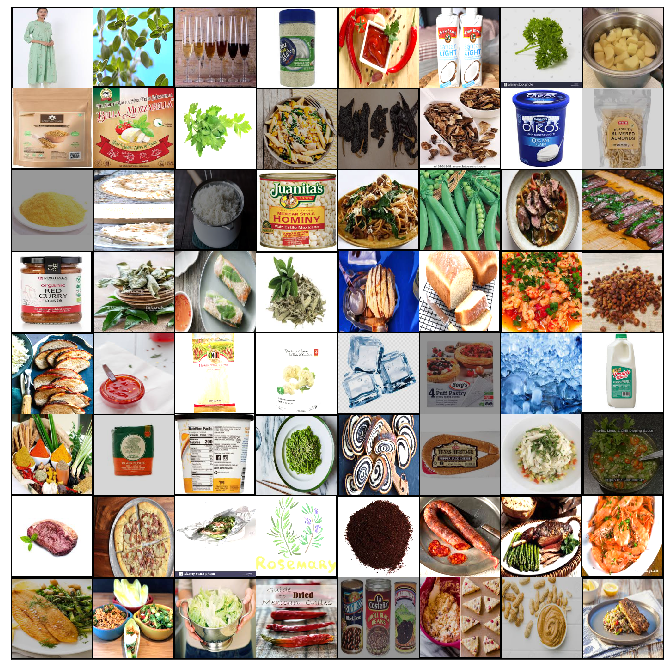

In [59]:
show_batch(train_dl)

# Model

In [60]:
class ResNet50MLC(nn.Module):
    '''
        Resnet-50 Image Multi-label Classification Model
    '''
    def __init__(self, output_size):
        super().__init__()
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        model.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(model.fc.in_features, output_size)
        )
        
        self.base_model = model
        self.sigm = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigm(self.base_model(x))
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.binary_cross_entropy(out, labels)
        
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.binary_cross_entropy(out, labels)
#         acc = 
        return {'loss': loss.cpu().detach()}
        
        
        


In [66]:
model = to_device(ResNet50MLC(len(ds.class_to_idx)), device)

In [ ]:
for images, labels in train_dl:
    out = model(images)
    